In [31]:
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.distributions.normal import Normal
import torch.nn.functional as F
import gc
import imutils
import math

import data
import models
from models import *

In [32]:
device = "cuda:2"
LATENT_DIM = 64
NUM_GENERATORS = 3
ALPHA = 3

In [33]:
# We will work with the distilled data for the sake of simplicity of our work, it turns out that the distilled dataset contains only 0s and 1s

In [34]:
X_train, X_test, Y_train, Y_test = data.get_dataset_augmented()

train_dataset = TensorDataset(X_train,Y_train)
train_dataloader = DataLoader(train_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset = TensorDataset(X_test,Y_test)
test_dataloader = DataLoader(test_dataset,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

model_VAE = torch.load("../symmetry_2/VAE.pt")
model_VAE = model_VAE.to(device)

In [35]:
model_VAE.eval()
train_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_train.to(device)))).cpu().detach()
test_Z = model_VAE.fc2(model_VAE.fc_mu(model_VAE.encoder(X_test.to(device)))).cpu().detach()

train_dataset_Z = TensorDataset(train_Z,Y_train)
train_dataloader_Z = DataLoader(train_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

test_dataset_Z = TensorDataset(test_Z,Y_test)
test_dataloader_Z = DataLoader(test_dataset_Z,
                              batch_size=4096,
                              shuffle=True,
                              drop_last = True,
                              num_workers=8,
                              pin_memory = False)

In [36]:
model_fe = models.MLP(feature_size=LATENT_DIM).to(device)
model_fd = models.MLP(feature_size=LATENT_DIM).to(device)
# model_fo = models.LatentOracle().to(device)
model_fo = models.LatentOracle().to(device) # Since we ony have two elements

model_symmetry = models.GroupLatent(num_features=LATENT_DIM,num_generators=NUM_GENERATORS).to(device)

optimiser_fe = torch.optim.Adam(model_fe.parameters(), lr = 1e-3)
optimiser_fd = torch.optim.Adam(model_fd.parameters(), lr = 1e-3)
optimiser_fo = torch.optim.Adam(model_fo.parameters(), lr = 1e-3)
optimiser_symmetry = torch.optim.Adam(model_symmetry.parameters(), lr = 1e-3)


criterion_mse = nn.MSELoss()
criterion_BCE = nn.BCEWithLogitsLoss()
criterion_entropy = nn.CrossEntropyLoss(reduction = 'none')

/global/homes/d/diptarko/miniconda3/envs/work/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [ ]:
loss_S_closure = []
loss_S_orth = []
loss_S_collapse = []

loss_space = []
loss_oracle = []
for i in range(300):
    
    loss_S_closure_ = 0
    loss_S_orth_ = 0
    loss_S_collapse_ = 0

    loss_space_ = 0
    loss_oracle_ = 0
    
    for Z,M in tqdm(train_dataloader_Z):
        Z = Z.to(device)
        M = M.type(torch.LongTensor).to(device)
        
        optimiser_fd.zero_grad()
        optimiser_fe.zero_grad()
        optimiser_fo.zero_grad()
        optimiser_symmetry.zero_grad()

        theta = [(2*torch.rand(Z.shape[0],device = device) - 1) for i in range(NUM_GENERATORS)]  #Sampling

        P = model_fe(Z)
        P_S = model_symmetry(theta = theta, x = P)
        Z_S = model_fd(P_S)
        m = model_fo(Z)
        m_S = model_fo(Z_S)
        Z_P = model_fd(P)

        loss1 = criterion_entropy(m_S,torch.argmax(torch.softmax(m,-1), -1))
        loss2 = model_symmetry.orthogonal_loss()
        loss3 = model_symmetry.collapse_loss()
        loss5 = criterion_mse(Z,Z_P)
        loss6 = criterion_entropy(m.squeeze(),M)
        
        loss_S = torch.mean(loss1*torch.exp(-ALPHA*loss6)) + loss2 + loss3
        loss_Ae = loss5 # loss1 is not added since it is adjusted in the grad calculations
        loss_O = torch.mean(loss6)
        
        loss_S.backward(retain_graph=True)
        optimiser_symmetry.step()
        loss_Ae.backward(retain_graph=True)
        optimiser_fd.step() 
        optimiser_fe.step()
        optimiser_fo.zero_grad()
        loss_O.backward(retain_graph=True)
        optimiser_fo.step()
    
        
        loss_S_closure_ += torch.mean(loss1*torch.exp(-ALPHA*loss6)).item()
        try:
            loss_S_orth_ += loss2.item()
        except AttributeError:
            loss_S_orth_ = 0

        loss_S_collapse_ += loss3.item()

        loss_space_ += loss5.item()
        loss_oracle_ += loss_O.item()
    
    loss_S_closure_ /= len(train_dataloader)
    loss_S_orth_ /= len(train_dataloader)
    loss_S_collapse_ /= len(train_dataloader)

    loss_space_ /= len(train_dataloader)
    loss_oracle_ /= len(train_dataloader)
    
    
    loss_S_closure.append(loss_S_closure_)
    loss_S_collapse.append(loss_S_collapse_)
    loss_S_orth.append(loss_S_orth_)
    
    loss_space.append(loss_space_)
    loss_oracle.append(loss_oracle_)
    
    print(f"EPOCH {i} complete")
    print("=====================")
    print("Symmetry Closure Loss ",loss_S_closure_)
    print("Symmetry Orthogonality Loss ",loss_S_orth_)
    print("Symmetry Collapse Loss ",loss_S_collapse_)
    
    print("Space Inversion Loss ",loss_space_)
    print("Oracle loss",loss_oracle_)
    print("=====================")
    

100%|██████████| 166/166 [00:03<00:00, 51.72it/s]


EPOCH 0 complete
Symmetry Closure Loss  0.01691551263870514
Symmetry Orthogonality Loss  0.01642819414902703
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.1480499625076955
Oracle loss 1.7900903849716645


100%|██████████| 166/166 [00:03<00:00, 51.61it/s]


EPOCH 1 complete
Symmetry Closure Loss  0.02474169972835176
Symmetry Orthogonality Loss  0.005898283539250134
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0022982425857279226
Oracle loss 1.4498755156275738


100%|██████████| 166/166 [00:03<00:00, 51.36it/s]


EPOCH 2 complete
Symmetry Closure Loss  0.027825119725641716
Symmetry Orthogonality Loss  0.005806957786700812
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015429439126929067
Oracle loss 1.2695711025272507


100%|██████████| 166/166 [00:03<00:00, 49.39it/s]


EPOCH 3 complete
Symmetry Closure Loss  0.03281951574496476
Symmetry Orthogonality Loss  0.005559327625052397
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015068487144995436
Oracle loss 1.1345988971641265


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 4 complete
Symmetry Closure Loss  0.03561297000711223
Symmetry Orthogonality Loss  0.005706756695521524
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018595811225058712
Oracle loss 1.0409311106406063


100%|██████████| 166/166 [00:03<00:00, 49.76it/s]


EPOCH 5 complete
Symmetry Closure Loss  0.03619088322283274
Symmetry Orthogonality Loss  0.005797736287812691
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0023802731940747203
Oracle loss 0.9724304112325232


100%|██████████| 166/166 [00:03<00:00, 52.24it/s]


EPOCH 6 complete
Symmetry Closure Loss  0.03497890602931919
Symmetry Orthogonality Loss  0.005798573852572815
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002707354800147285
Oracle loss 0.9210255242973925


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 7 complete
Symmetry Closure Loss  0.03356475836361747
Symmetry Orthogonality Loss  0.005683821468917002
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0028283818462212762
Oracle loss 0.8781816388469145


100%|██████████| 166/166 [00:03<00:00, 50.10it/s]


EPOCH 8 complete
Symmetry Closure Loss  0.031667210307555746
Symmetry Orthogonality Loss  0.005612493896610047
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0024415518140352994
Oracle loss 0.8442975936165775


100%|██████████| 166/166 [00:03<00:00, 52.51it/s]


EPOCH 9 complete
Symmetry Closure Loss  0.03048872735620622
Symmetry Orthogonality Loss  0.005473878243040428
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00222576082212828
Oracle loss 0.8210901657500899


100%|██████████| 166/166 [00:03<00:00, 51.64it/s]


EPOCH 10 complete
Symmetry Closure Loss  0.0294569375060768
Symmetry Orthogonality Loss  0.005417105478111161
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002297785716602601
Oracle loss 0.8048975449728678


100%|██████████| 166/166 [00:03<00:00, 50.55it/s]


EPOCH 11 complete
Symmetry Closure Loss  0.02855218696710934
Symmetry Orthogonality Loss  0.005372131386412734
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002284919147390917
Oracle loss 0.7930472503943615


100%|██████████| 166/166 [00:03<00:00, 51.95it/s]


EPOCH 12 complete
Symmetry Closure Loss  0.027875172972948437
Symmetry Orthogonality Loss  0.005440723308059107
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002246281181192811
Oracle loss 0.7842018457062273


100%|██████████| 166/166 [00:03<00:00, 51.37it/s]


EPOCH 13 complete
Symmetry Closure Loss  0.027256263947361206
Symmetry Orthogonality Loss  0.0054989212517996865
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002178294764388442
Oracle loss 0.77717834028853


100%|██████████| 166/166 [00:03<00:00, 50.40it/s]


EPOCH 14 complete
Symmetry Closure Loss  0.026619449078318584
Symmetry Orthogonality Loss  0.0053126396112009346
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002107341306042824
Oracle loss 0.7717338513178997


100%|██████████| 166/166 [00:03<00:00, 51.65it/s]


EPOCH 15 complete
Symmetry Closure Loss  0.02608622509582215
Symmetry Orthogonality Loss  0.005376412123666111
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002045049651873758
Oracle loss 0.7674357959304947


100%|██████████| 166/166 [00:03<00:00, 51.60it/s]


EPOCH 16 complete
Symmetry Closure Loss  0.025593555521175086
Symmetry Orthogonality Loss  0.005272572731083057
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.002027882918777191
Oracle loss 0.7638157871832331


100%|██████████| 166/166 [00:03<00:00, 50.62it/s]


EPOCH 17 complete
Symmetry Closure Loss  0.02501088610839054
Symmetry Orthogonality Loss  0.005160533845514418
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0019345185235535435
Oracle loss 0.7608461444636425


100%|██████████| 166/166 [00:03<00:00, 51.40it/s]


EPOCH 18 complete
Symmetry Closure Loss  0.02463311335094363
Symmetry Orthogonality Loss  0.005261452660996871
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018721739396856851
Oracle loss 0.7582541625183749


100%|██████████| 166/166 [00:03<00:00, 51.15it/s]


EPOCH 19 complete
Symmetry Closure Loss  0.024036262184381485
Symmetry Orthogonality Loss  0.005176767274872007
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0018720258432664875
Oracle loss 0.7561989649232611


100%|██████████| 166/166 [00:03<00:00, 51.44it/s]


EPOCH 20 complete
Symmetry Closure Loss  0.023554352785359663
Symmetry Orthogonality Loss  0.005189409221421523
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017774177817571684
Oracle loss 0.7543277568127735


100%|██████████| 166/166 [00:03<00:00, 48.23it/s]


EPOCH 21 complete
Symmetry Closure Loss  0.02309308217905731
Symmetry Orthogonality Loss  0.005087510870590088
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0017014580473012056
Oracle loss 0.7530197953603354


100%|██████████| 166/166 [00:03<00:00, 52.89it/s]


EPOCH 22 complete
Symmetry Closure Loss  0.022812541192734098
Symmetry Orthogonality Loss  0.005090257164135754
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001651217759844948
Oracle loss 0.7514559084392456


100%|██████████| 166/166 [00:03<00:00, 52.98it/s]


EPOCH 23 complete
Symmetry Closure Loss  0.022543243199856167
Symmetry Orthogonality Loss  0.005118597590600152
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015548656081657362
Oracle loss 0.7500904001385332


100%|██████████| 166/166 [00:03<00:00, 52.10it/s]


EPOCH 24 complete
Symmetry Closure Loss  0.022189698642097324
Symmetry Orthogonality Loss  0.005077192318592086
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0015119664702025882
Oracle loss 0.749254988977708


100%|██████████| 166/166 [00:03<00:00, 52.45it/s]


EPOCH 25 complete
Symmetry Closure Loss  0.0220093319910657
Symmetry Orthogonality Loss  0.004997476091024926
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014368493084694787
Oracle loss 0.7481321354946459


100%|██████████| 166/166 [00:03<00:00, 51.56it/s]


EPOCH 26 complete
Symmetry Closure Loss  0.021754627744386714
Symmetry Orthogonality Loss  0.0048702157871146875
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0014185266182140772
Oracle loss 0.7473530762166862


100%|██████████| 166/166 [00:03<00:00, 49.67it/s]


EPOCH 27 complete
Symmetry Closure Loss  0.021507131968097514
Symmetry Orthogonality Loss  0.004834174018644963
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013530629684206054
Oracle loss 0.7463482388530869


100%|██████████| 166/166 [00:03<00:00, 51.01it/s]


EPOCH 28 complete
Symmetry Closure Loss  0.02141148819172957
Symmetry Orthogonality Loss  0.004849446317495172
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013369124113436204
Oracle loss 0.7453338511018868


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 29 complete
Symmetry Closure Loss  0.021309273743844896
Symmetry Orthogonality Loss  0.004833281076659101
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0013057430525848933
Oracle loss 0.7445871384747057


100%|██████████| 166/166 [00:03<00:00, 51.38it/s]


EPOCH 30 complete
Symmetry Closure Loss  0.021092448181596148
Symmetry Orthogonality Loss  0.00483874680407076
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012953250131749335
Oracle loss 0.7436096542570965


100%|██████████| 166/166 [00:03<00:00, 49.37it/s]


EPOCH 31 complete
Symmetry Closure Loss  0.021157051369278545
Symmetry Orthogonality Loss  0.004873180989153594
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012185870254614267
Oracle loss 0.7428499567939575


100%|██████████| 166/166 [00:03<00:00, 51.66it/s]


EPOCH 32 complete
Symmetry Closure Loss  0.021016145472874843
Symmetry Orthogonality Loss  0.004864414331940822
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0012330753042878785
Oracle loss 0.7416183287838856


100%|██████████| 166/166 [00:03<00:00, 49.07it/s]


EPOCH 33 complete
Symmetry Closure Loss  0.02094215547374214
Symmetry Orthogonality Loss  0.0047271993791078585
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011931671613703918
Oracle loss 0.7403687414634659


100%|██████████| 166/166 [00:03<00:00, 51.31it/s]


EPOCH 34 complete
Symmetry Closure Loss  0.020897737311491048
Symmetry Orthogonality Loss  0.004652692692309439
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011877737341852612
Oracle loss 0.7391571223017681


100%|██████████| 166/166 [00:03<00:00, 52.64it/s]


EPOCH 35 complete
Symmetry Closure Loss  0.020919040170868475
Symmetry Orthogonality Loss  0.004791122659232961
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011818941222526223
Oracle loss 0.7375000571630087


100%|██████████| 166/166 [00:03<00:00, 53.07it/s]


EPOCH 36 complete
Symmetry Closure Loss  0.0208292063213436
Symmetry Orthogonality Loss  0.004712920922067869
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011814054244068865
Oracle loss 0.7357492102197853


100%|██████████| 166/166 [00:03<00:00, 47.21it/s]


EPOCH 37 complete
Symmetry Closure Loss  0.02081056733626917
Symmetry Orthogonality Loss  0.00463632234170225
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011605724070995417
Oracle loss 0.7338605943214462


100%|██████████| 166/166 [00:03<00:00, 52.03it/s]


EPOCH 38 complete
Symmetry Closure Loss  0.020636844863913144
Symmetry Orthogonality Loss  0.004663815309506762
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011675353484587318
Oracle loss 0.732093308345381


100%|██████████| 166/166 [00:03<00:00, 48.76it/s]


EPOCH 39 complete
Symmetry Closure Loss  0.020428677134395362
Symmetry Orthogonality Loss  0.004717193681365216
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011558518808121871
Oracle loss 0.7304127277380013


100%|██████████| 166/166 [00:03<00:00, 53.28it/s]


EPOCH 40 complete
Symmetry Closure Loss  0.020387446934200196
Symmetry Orthogonality Loss  0.004704158708273646
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011268093900093023
Oracle loss 0.7286399624433862


100%|██████████| 166/166 [00:03<00:00, 51.41it/s]


EPOCH 41 complete
Symmetry Closure Loss  0.02008338826876807
Symmetry Orthogonality Loss  0.004688647598117949
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011457006895146053
Oracle loss 0.7272376669458596


100%|██████████| 166/166 [00:03<00:00, 51.16it/s]


EPOCH 42 complete
Symmetry Closure Loss  0.01979532528174929
Symmetry Orthogonality Loss  0.004593504887321089
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011259358778107822
Oracle loss 0.7258499670459564


100%|██████████| 166/166 [00:03<00:00, 47.97it/s]


EPOCH 43 complete
Symmetry Closure Loss  0.019569866931492305
Symmetry Orthogonality Loss  0.004579537461163947
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011043403801194068
Oracle loss 0.7246025161570814


100%|██████████| 166/166 [00:03<00:00, 48.58it/s]


EPOCH 44 complete
Symmetry Closure Loss  0.01939565073474344
Symmetry Orthogonality Loss  0.004483914415138852
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010960691226982926
Oracle loss 0.7233291979295662


100%|██████████| 166/166 [00:03<00:00, 52.09it/s]


EPOCH 45 complete
Symmetry Closure Loss  0.019129560789070934
Symmetry Orthogonality Loss  0.004363238303753805
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010734571165725005
Oracle loss 0.7224599776497806


100%|██████████| 166/166 [00:03<00:00, 52.26it/s]


EPOCH 46 complete
Symmetry Closure Loss  0.01876017132616905
Symmetry Orthogonality Loss  0.004440507740736097
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010747514059907387
Oracle loss 0.721425542630345


100%|██████████| 166/166 [00:03<00:00, 53.02it/s]


EPOCH 47 complete
Symmetry Closure Loss  0.018529717664582182
Symmetry Orthogonality Loss  0.004453944875465998
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0011168924947157054
Oracle loss 0.7208023764282824


100%|██████████| 166/166 [00:03<00:00, 50.72it/s]


EPOCH 48 complete
Symmetry Closure Loss  0.018303841969604235
Symmetry Orthogonality Loss  0.0043744414396786006
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010707346832587283
Oracle loss 0.7196953483374722


100%|██████████| 166/166 [00:03<00:00, 47.65it/s]


EPOCH 49 complete
Symmetry Closure Loss  0.01799409424729017
Symmetry Orthogonality Loss  0.004431264655922641
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010511611243962389
Oracle loss 0.7189053939767631


100%|██████████| 166/166 [00:03<00:00, 49.43it/s]


EPOCH 50 complete
Symmetry Closure Loss  0.017707745443625623
Symmetry Orthogonality Loss  0.004498124049684729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009837985331198223
Oracle loss 0.7181015976940293


100%|██████████| 166/166 [00:03<00:00, 52.91it/s]


EPOCH 51 complete
Symmetry Closure Loss  0.01755932709538793
Symmetry Orthogonality Loss  0.004402924281354231
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010625321224488947
Oracle loss 0.7173810716134956


100%|██████████| 166/166 [00:03<00:00, 48.35it/s]


EPOCH 52 complete
Symmetry Closure Loss  0.0173099445717701
Symmetry Orthogonality Loss  0.004371991804632616
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00103202538181893
Oracle loss 0.7166015164679792


100%|██████████| 166/166 [00:03<00:00, 52.00it/s]


EPOCH 53 complete
Symmetry Closure Loss  0.017005584898393555
Symmetry Orthogonality Loss  0.004293895994189633
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.001012955187730132
Oracle loss 0.7159051791013006


100%|██████████| 166/166 [00:03<00:00, 52.78it/s]


EPOCH 54 complete
Symmetry Closure Loss  0.016810771397662808
Symmetry Orthogonality Loss  0.0042297797030713185
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.00100202353654362
Oracle loss 0.7150408101369099


100%|██████████| 166/166 [00:03<00:00, 46.79it/s]


EPOCH 55 complete
Symmetry Closure Loss  0.016553487320127618
Symmetry Orthogonality Loss  0.004245109741115965
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010017685897940074
Oracle loss 0.7142778810966446


100%|██████████| 166/166 [00:03<00:00, 46.67it/s]


EPOCH 56 complete
Symmetry Closure Loss  0.016385626895016575
Symmetry Orthogonality Loss  0.004226108627247972
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0010009448139378465
Oracle loss 0.713571473776576


100%|██████████| 166/166 [00:03<00:00, 49.87it/s]


EPOCH 57 complete
Symmetry Closure Loss  0.01611355529447277
Symmetry Orthogonality Loss  0.004171635499729
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009617296966909241
Oracle loss 0.7125235756477678


100%|██████████| 166/166 [00:03<00:00, 49.50it/s]


EPOCH 58 complete
Symmetry Closure Loss  0.015949305842619343
Symmetry Orthogonality Loss  0.004021563978181277
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009864659300382551
Oracle loss 0.7117800044726177


100%|██████████| 166/166 [00:03<00:00, 49.40it/s]


EPOCH 59 complete
Symmetry Closure Loss  0.015759446439389365
Symmetry Orthogonality Loss  0.004065331495198679
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009440181584725807
Oracle loss 0.7107784543410841


100%|██████████| 166/166 [00:03<00:00, 51.52it/s]


EPOCH 60 complete
Symmetry Closure Loss  0.015541425367525542
Symmetry Orthogonality Loss  0.003996682420642261
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009340007813277105
Oracle loss 0.70964270183839


100%|██████████| 166/166 [00:03<00:00, 49.73it/s]


EPOCH 61 complete
Symmetry Closure Loss  0.01527137695306755
Symmetry Orthogonality Loss  0.004014984404398914
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000943504676786644
Oracle loss 0.7087182039956013


100%|██████████| 166/166 [00:03<00:00, 52.20it/s]


EPOCH 62 complete
Symmetry Closure Loss  0.015100725758147526
Symmetry Orthogonality Loss  0.004029305888822369
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009336793330268014
Oracle loss 0.7072096510105822


100%|██████████| 166/166 [00:03<00:00, 49.15it/s]


EPOCH 63 complete
Symmetry Closure Loss  0.01483348393476153
Symmetry Orthogonality Loss  0.004086190186642918
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009437474640961513
Oracle loss 0.7063436070120478


100%|██████████| 166/166 [00:03<00:00, 49.03it/s]


EPOCH 64 complete
Symmetry Closure Loss  0.014703519204743656
Symmetry Orthogonality Loss  0.004145306896934488
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009289851169528283
Oracle loss 0.7051382693181555


100%|██████████| 166/166 [00:03<00:00, 48.27it/s]


EPOCH 65 complete
Symmetry Closure Loss  0.01433890003217272
Symmetry Orthogonality Loss  0.0040704365216577085
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009004801675868053
Oracle loss 0.7041971963572214


100%|██████████| 166/166 [00:03<00:00, 52.05it/s]


EPOCH 66 complete
Symmetry Closure Loss  0.014100717375032514
Symmetry Orthogonality Loss  0.003924953160773828
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009307066527060626
Oracle loss 0.7034145651093449


100%|██████████| 166/166 [00:03<00:00, 50.03it/s]


EPOCH 67 complete
Symmetry Closure Loss  0.01388978334817003
Symmetry Orthogonality Loss  0.003935480779261294
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009007566932487829
Oracle loss 0.702490385038307


100%|██████████| 166/166 [00:03<00:00, 51.26it/s]


EPOCH 68 complete
Symmetry Closure Loss  0.013574249397245157
Symmetry Orthogonality Loss  0.004049621982477516
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008920892134746425
Oracle loss 0.7016518999295063


100%|██████████| 166/166 [00:03<00:00, 49.00it/s]


EPOCH 69 complete
Symmetry Closure Loss  0.013380507141890296
Symmetry Orthogonality Loss  0.003925800925199257
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008803437213576118
Oracle loss 0.7012399122657547


100%|██████████| 166/166 [00:03<00:00, 51.06it/s]


EPOCH 70 complete
Symmetry Closure Loss  0.013200412840997598
Symmetry Orthogonality Loss  0.003975388216673879
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0009062183135138623
Oracle loss 0.7003172679119799


100%|██████████| 166/166 [00:03<00:00, 50.41it/s]


EPOCH 71 complete
Symmetry Closure Loss  0.013057534902704409
Symmetry Orthogonality Loss  0.0038511544137811624
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008348198817953108
Oracle loss 0.7000834737197462


100%|██████████| 166/166 [00:03<00:00, 52.32it/s]


EPOCH 72 complete
Symmetry Closure Loss  0.012851549497614783
Symmetry Orthogonality Loss  0.0038763075514348694
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000850204338743183
Oracle loss 0.6994934387235756


100%|██████████| 166/166 [00:03<00:00, 48.22it/s]


EPOCH 73 complete
Symmetry Closure Loss  0.012576477703110999
Symmetry Orthogonality Loss  0.0038449959899579367
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008443327293119741
Oracle loss 0.6988386831369745


100%|██████████| 166/166 [00:03<00:00, 51.70it/s]


EPOCH 74 complete
Symmetry Closure Loss  0.012466254666537405
Symmetry Orthogonality Loss  0.0037920283776404985
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008182607034322278
Oracle loss 0.6984790872378521


100%|██████████| 166/166 [00:03<00:00, 50.21it/s]


EPOCH 75 complete
Symmetry Closure Loss  0.012284716355603143
Symmetry Orthogonality Loss  0.0037658838990021004
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008335474767043334
Oracle loss 0.6980580166879907


100%|██████████| 166/166 [00:03<00:00, 52.85it/s]


EPOCH 76 complete
Symmetry Closure Loss  0.012077398065208312
Symmetry Orthogonality Loss  0.0038047103654503464
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008160877777880663
Oracle loss 0.697825100407543


100%|██████████| 166/166 [00:03<00:00, 50.91it/s]


EPOCH 77 complete
Symmetry Closure Loss  0.011988894149930361
Symmetry Orthogonality Loss  0.003780342708622296
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0008190278516498854
Oracle loss 0.6972067176577557


100%|██████████| 166/166 [00:03<00:00, 51.50it/s]


EPOCH 78 complete
Symmetry Closure Loss  0.011821409816438535
Symmetry Orthogonality Loss  0.0036479739404945487
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007904945306075984
Oracle loss 0.6968098706509693


100%|██████████| 166/166 [00:03<00:00, 47.64it/s]


EPOCH 79 complete
Symmetry Closure Loss  0.011652734315763396
Symmetry Orthogonality Loss  0.0036512601711080374
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007888149818635534
Oracle loss 0.6965504238404423


100%|██████████| 166/166 [00:03<00:00, 50.60it/s]


EPOCH 80 complete
Symmetry Closure Loss  0.011592370951660427
Symmetry Orthogonality Loss  0.003597101310256824
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007616892135814281
Oracle loss 0.6962493220007563


100%|██████████| 166/166 [00:03<00:00, 48.60it/s]


EPOCH 81 complete
Symmetry Closure Loss  0.011396751200488532
Symmetry Orthogonality Loss  0.003549542024181819
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007788197664089546
Oracle loss 0.6959211312862764


100%|██████████| 166/166 [00:03<00:00, 48.72it/s]


EPOCH 82 complete
Symmetry Closure Loss  0.011380788269845477
Symmetry Orthogonality Loss  0.003627892429323261
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007437378335014794
Oracle loss 0.6957419651100435


100%|██████████| 166/166 [00:03<00:00, 51.35it/s]


EPOCH 83 complete
Symmetry Closure Loss  0.011132978520030716
Symmetry Orthogonality Loss  0.0037243928092655287
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007361361875440028
Oracle loss 0.6953210888138737


100%|██████████| 166/166 [00:03<00:00, 51.57it/s]


EPOCH 84 complete
Symmetry Closure Loss  0.011033494109624481
Symmetry Orthogonality Loss  0.0036277279204475774
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007194870359163327
Oracle loss 0.6951723741479667


100%|██████████| 166/166 [00:03<00:00, 50.48it/s]


EPOCH 85 complete
Symmetry Closure Loss  0.010965094727699656
Symmetry Orthogonality Loss  0.003571497259594231
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007380027119182499
Oracle loss 0.6951121120567781


100%|██████████| 166/166 [00:03<00:00, 46.56it/s]


EPOCH 86 complete
Symmetry Closure Loss  0.010764887500329908
Symmetry Orthogonality Loss  0.0036173994310693927
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006789568329863923
Oracle loss 0.6948203042329076


100%|██████████| 166/166 [00:03<00:00, 49.61it/s]


EPOCH 87 complete
Symmetry Closure Loss  0.010711104524916554
Symmetry Orthogonality Loss  0.0035106663799743696
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0007197446882702321
Oracle loss 0.6945264149143036


100%|██████████| 166/166 [00:03<00:00, 50.86it/s]


EPOCH 88 complete
Symmetry Closure Loss  0.010606089012181184
Symmetry Orthogonality Loss  0.0034715061676295765
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006782609751274114
Oracle loss 0.6943425751594176


100%|██████████| 166/166 [00:03<00:00, 51.75it/s]


EPOCH 89 complete
Symmetry Closure Loss  0.010483683782618448
Symmetry Orthogonality Loss  0.0034287060535209903
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006944884392517024
Oracle loss 0.6941204825079584


100%|██████████| 166/166 [00:03<00:00, 51.43it/s]


EPOCH 90 complete
Symmetry Closure Loss  0.01040979149942118
Symmetry Orthogonality Loss  0.003353432156089469
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006844044451921595
Oracle loss 0.6938264922923353


100%|██████████| 166/166 [00:03<00:00, 49.02it/s]


EPOCH 91 complete
Symmetry Closure Loss  0.010290769641343728
Symmetry Orthogonality Loss  0.0034438712502751186
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006830891855874559
Oracle loss 0.6938659936548716


100%|██████████| 166/166 [00:03<00:00, 50.25it/s]


EPOCH 92 complete
Symmetry Closure Loss  0.01019492500226002
Symmetry Orthogonality Loss  0.003409152404483722
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006713750439062042
Oracle loss 0.6935235100338258


100%|██████████| 166/166 [00:03<00:00, 48.29it/s]


EPOCH 93 complete
Symmetry Closure Loss  0.010064449116408107
Symmetry Orthogonality Loss  0.0033490353205005625
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006616944243783603
Oracle loss 0.6934009172830237


100%|██████████| 166/166 [00:03<00:00, 51.21it/s]


EPOCH 94 complete
Symmetry Closure Loss  0.010002830638045287
Symmetry Orthogonality Loss  0.0033359061800369836
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006770760968260197
Oracle loss 0.6931248885321329


100%|██████████| 166/166 [00:03<00:00, 50.48it/s]


EPOCH 95 complete
Symmetry Closure Loss  0.010002054290913314
Symmetry Orthogonality Loss  0.0032436834867056235
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006359933338307563
Oracle loss 0.6932171619082071


100%|██████████| 166/166 [00:03<00:00, 51.38it/s]


EPOCH 96 complete
Symmetry Closure Loss  0.009806733236210534
Symmetry Orthogonality Loss  0.0032760243545881056
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000627322235714128
Oracle loss 0.6930990179619158


100%|██████████| 166/166 [00:03<00:00, 51.32it/s]


EPOCH 97 complete
Symmetry Closure Loss  0.009805116213364414
Symmetry Orthogonality Loss  0.0033402152763432765
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006529671279923901
Oracle loss 0.6928931208978216


100%|██████████| 166/166 [00:03<00:00, 49.66it/s]


EPOCH 98 complete
Symmetry Closure Loss  0.009847261510924044
Symmetry Orthogonality Loss  0.003292549015808267
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000654470759685185
Oracle loss 0.6927857355899122


100%|██████████| 166/166 [00:03<00:00, 48.26it/s]


EPOCH 99 complete
Symmetry Closure Loss  0.009688479461179799
Symmetry Orthogonality Loss  0.0032443802310041635
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006358949930395886
Oracle loss 0.6925374829625509


100%|██████████| 166/166 [00:03<00:00, 51.13it/s]


EPOCH 100 complete
Symmetry Closure Loss  0.009609326204083052
Symmetry Orthogonality Loss  0.003221759935897068
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006217822994958295
Oracle loss 0.6925756629691067


100%|██████████| 166/166 [00:03<00:00, 52.14it/s]


EPOCH 101 complete
Symmetry Closure Loss  0.009495421778410673
Symmetry Orthogonality Loss  0.003232416445782116
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006334936861313475
Oracle loss 0.6923741475645319


100%|██████████| 166/166 [00:03<00:00, 52.22it/s]


EPOCH 102 complete
Symmetry Closure Loss  0.009490072637437338
Symmetry Orthogonality Loss  0.0032610018128888256
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000614621069531955
Oracle loss 0.6923053210758301


100%|██████████| 166/166 [00:03<00:00, 52.40it/s]


EPOCH 103 complete
Symmetry Closure Loss  0.009447421368031976
Symmetry Orthogonality Loss  0.003258605486242078
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000604149970332587
Oracle loss 0.6921966294926333


100%|██████████| 166/166 [00:03<00:00, 51.12it/s]


EPOCH 104 complete
Symmetry Closure Loss  0.009352146182209253
Symmetry Orthogonality Loss  0.0031615073220377945
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006306050604781562
Oracle loss 0.6921082961272045


100%|██████████| 166/166 [00:03<00:00, 49.53it/s]


EPOCH 105 complete
Symmetry Closure Loss  0.00924708333472351
Symmetry Orthogonality Loss  0.003176168211825551
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005825126599043563
Oracle loss 0.6919943952416799


100%|██████████| 166/166 [00:03<00:00, 52.08it/s]


EPOCH 106 complete
Symmetry Closure Loss  0.00916852075494377
Symmetry Orthogonality Loss  0.003241661794382675
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006168381965309605
Oracle loss 0.6918559706354716


100%|██████████| 166/166 [00:03<00:00, 50.19it/s]


EPOCH 107 complete
Symmetry Closure Loss  0.00912877104346113
Symmetry Orthogonality Loss  0.0031741209544174104
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005796959840044581
Oracle loss 0.6919250046632376


100%|██████████| 166/166 [00:03<00:00, 50.32it/s]


EPOCH 108 complete
Symmetry Closure Loss  0.009082183710310653
Symmetry Orthogonality Loss  0.0031297834763999084
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006088759511336123
Oracle loss 0.691700228007443


100%|██████████| 166/166 [00:03<00:00, 48.34it/s]


EPOCH 109 complete
Symmetry Closure Loss  0.009063672423026109
Symmetry Orthogonality Loss  0.0031971172163128316
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006226954572477816
Oracle loss 0.6917887376733574


100%|██████████| 166/166 [00:03<00:00, 50.98it/s]


EPOCH 110 complete
Symmetry Closure Loss  0.008973348369619933
Symmetry Orthogonality Loss  0.0031679729883368297
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005938133282000648
Oracle loss 0.6915634497102484


100%|██████████| 166/166 [00:03<00:00, 48.67it/s]


EPOCH 111 complete
Symmetry Closure Loss  0.009014784969972918
Symmetry Orthogonality Loss  0.0031143099683931612
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006084493890892804
Oracle loss 0.6915943769805403


100%|██████████| 166/166 [00:03<00:00, 49.78it/s]


EPOCH 112 complete
Symmetry Closure Loss  0.008861608211377478
Symmetry Orthogonality Loss  0.003043977044388113
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0005830268979392363
Oracle loss 0.6914943880345448


100%|██████████| 166/166 [00:03<00:00, 50.14it/s]


EPOCH 113 complete
Symmetry Closure Loss  0.008841482613864074
Symmetry Orthogonality Loss  0.0029637938356924668
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.000583342459727449
Oracle loss 0.691404098128698


100%|██████████| 166/166 [00:03<00:00, 50.69it/s]


EPOCH 114 complete
Symmetry Closure Loss  0.008759891984602773
Symmetry Orthogonality Loss  0.0031227430017350846
Symmetry Collapse Loss  0.0
Space Inversion Loss  0.0006013155826479645
Oracle loss 0.6913010097411741


 99%|█████████▉| 165/166 [00:03<00:00, 63.75it/s]

In [17]:
loss1*torch.exp(-loss6)

tensor([0.1372, 0.0533, 0.2092,  ..., 0.0781, 0.1906, 0.2512], device='cuda:2',
       grad_fn=<MulBackward0>)

In [15]:
loss6

tensor([2.6804, 3.6538, 2.3000,  ..., 2.9190, 2.1183, 2.1514], device='cuda:2',
       grad_fn=<NllLossBackward0>)

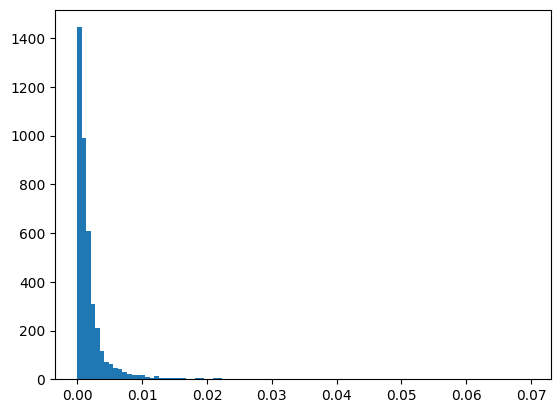

In [29]:
plt.hist(torch.exp(-3*loss6).detach().cpu(), bins = 100)
plt.show()

In [ ]:
plt.plot(loss_S_closure, label =  "Closure")
plt.plot(loss_S_orth, label =  "Orthogonality")
plt.plot(loss_oracle, label =  "Oracle")
plt.plot(loss_space, label =  "Space")
plt.yscale("log")
plt.legend()

In [46]:
X, Y = next(iter(train_dataloader_Z))
X = X.to(device)
theta = 2*torch.ones(X.shape[0]) - 1 #Sampling
zero = torch.zeros(X.shape[0], device = device)
theta = theta.to(device)


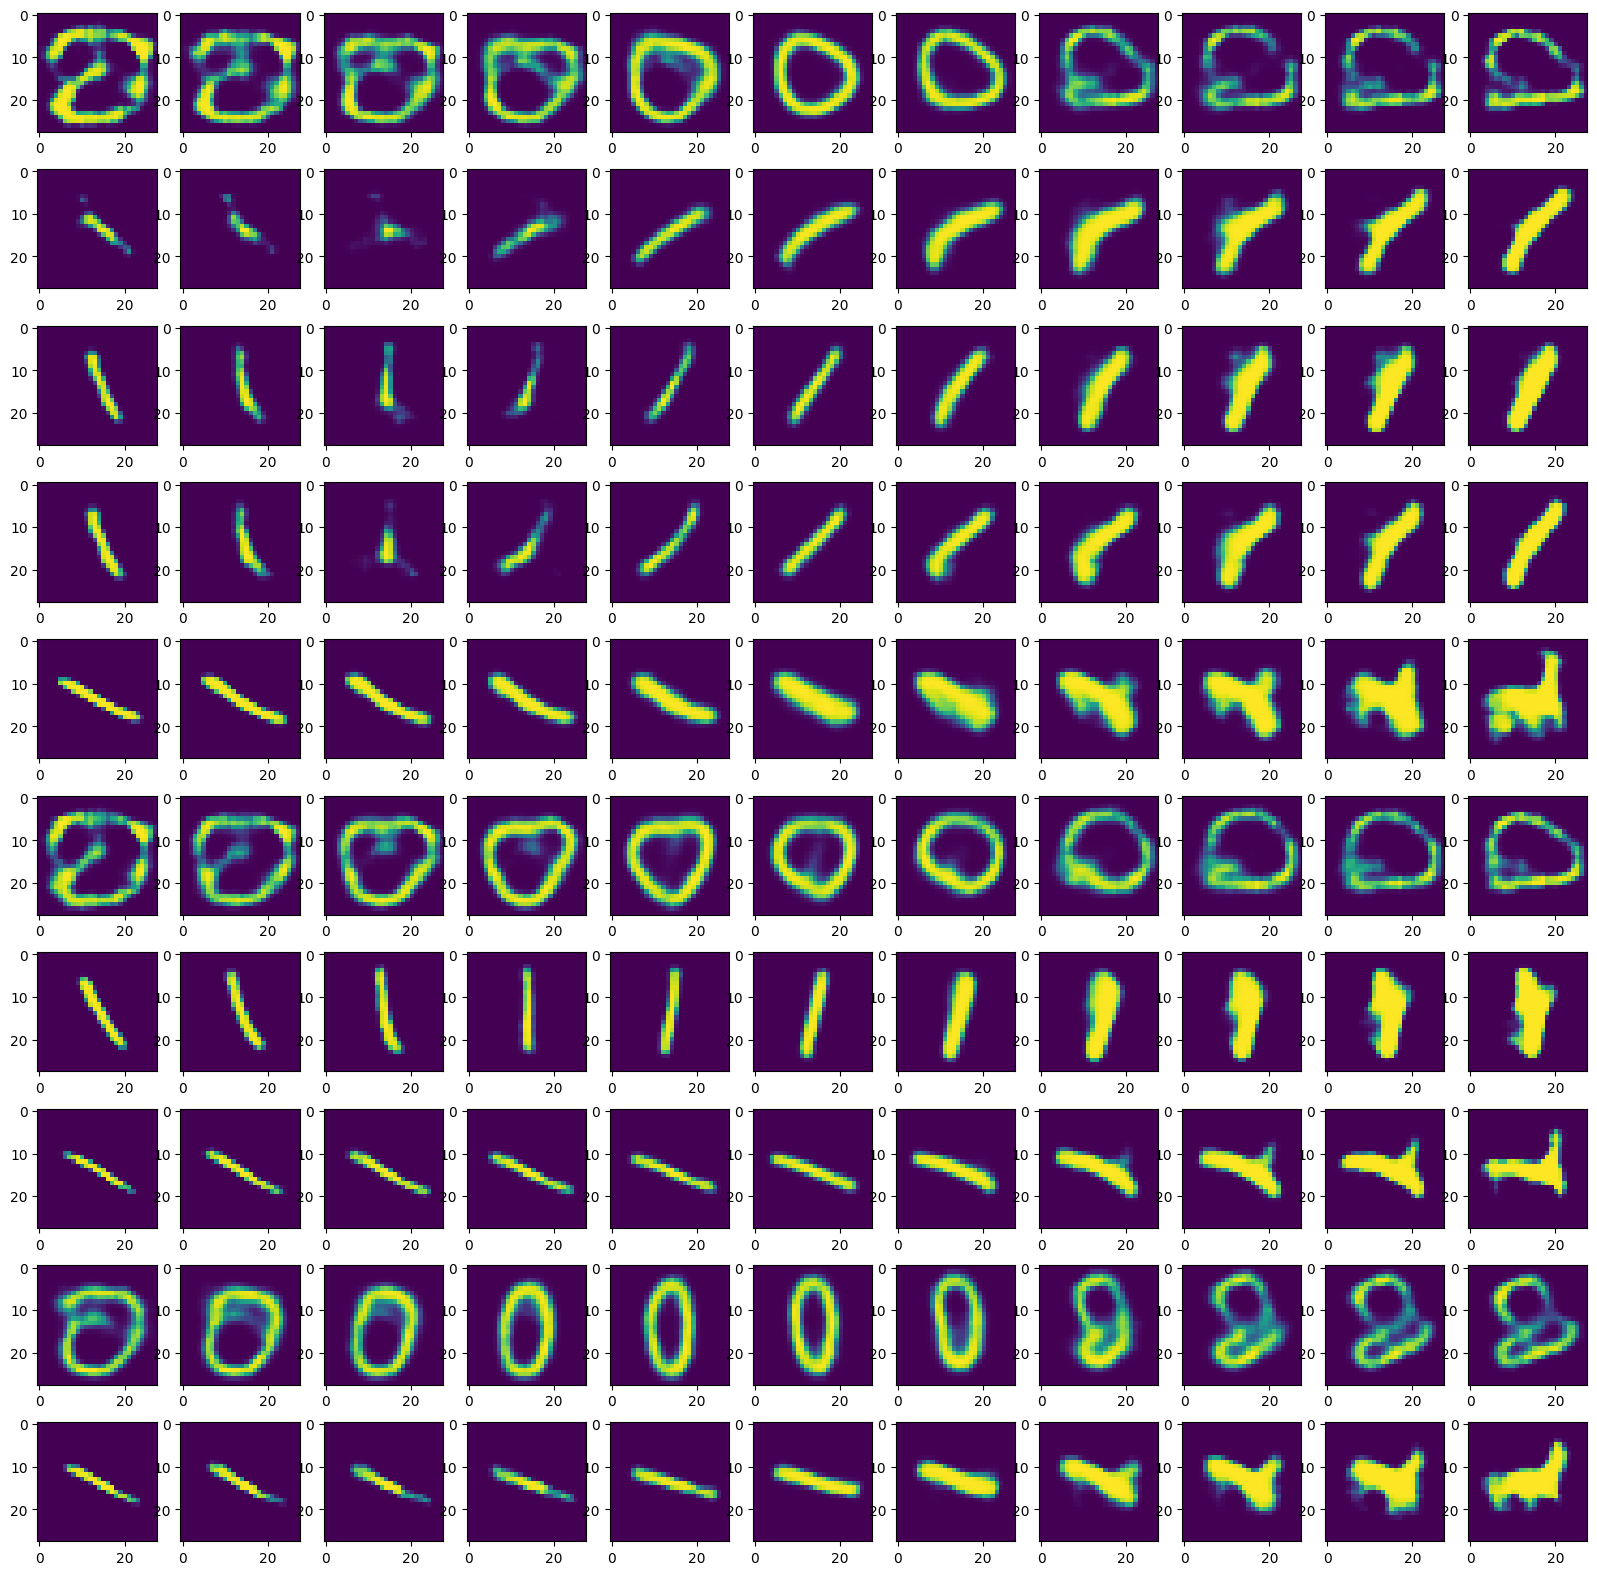

In [47]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([theta*(step),zero,zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

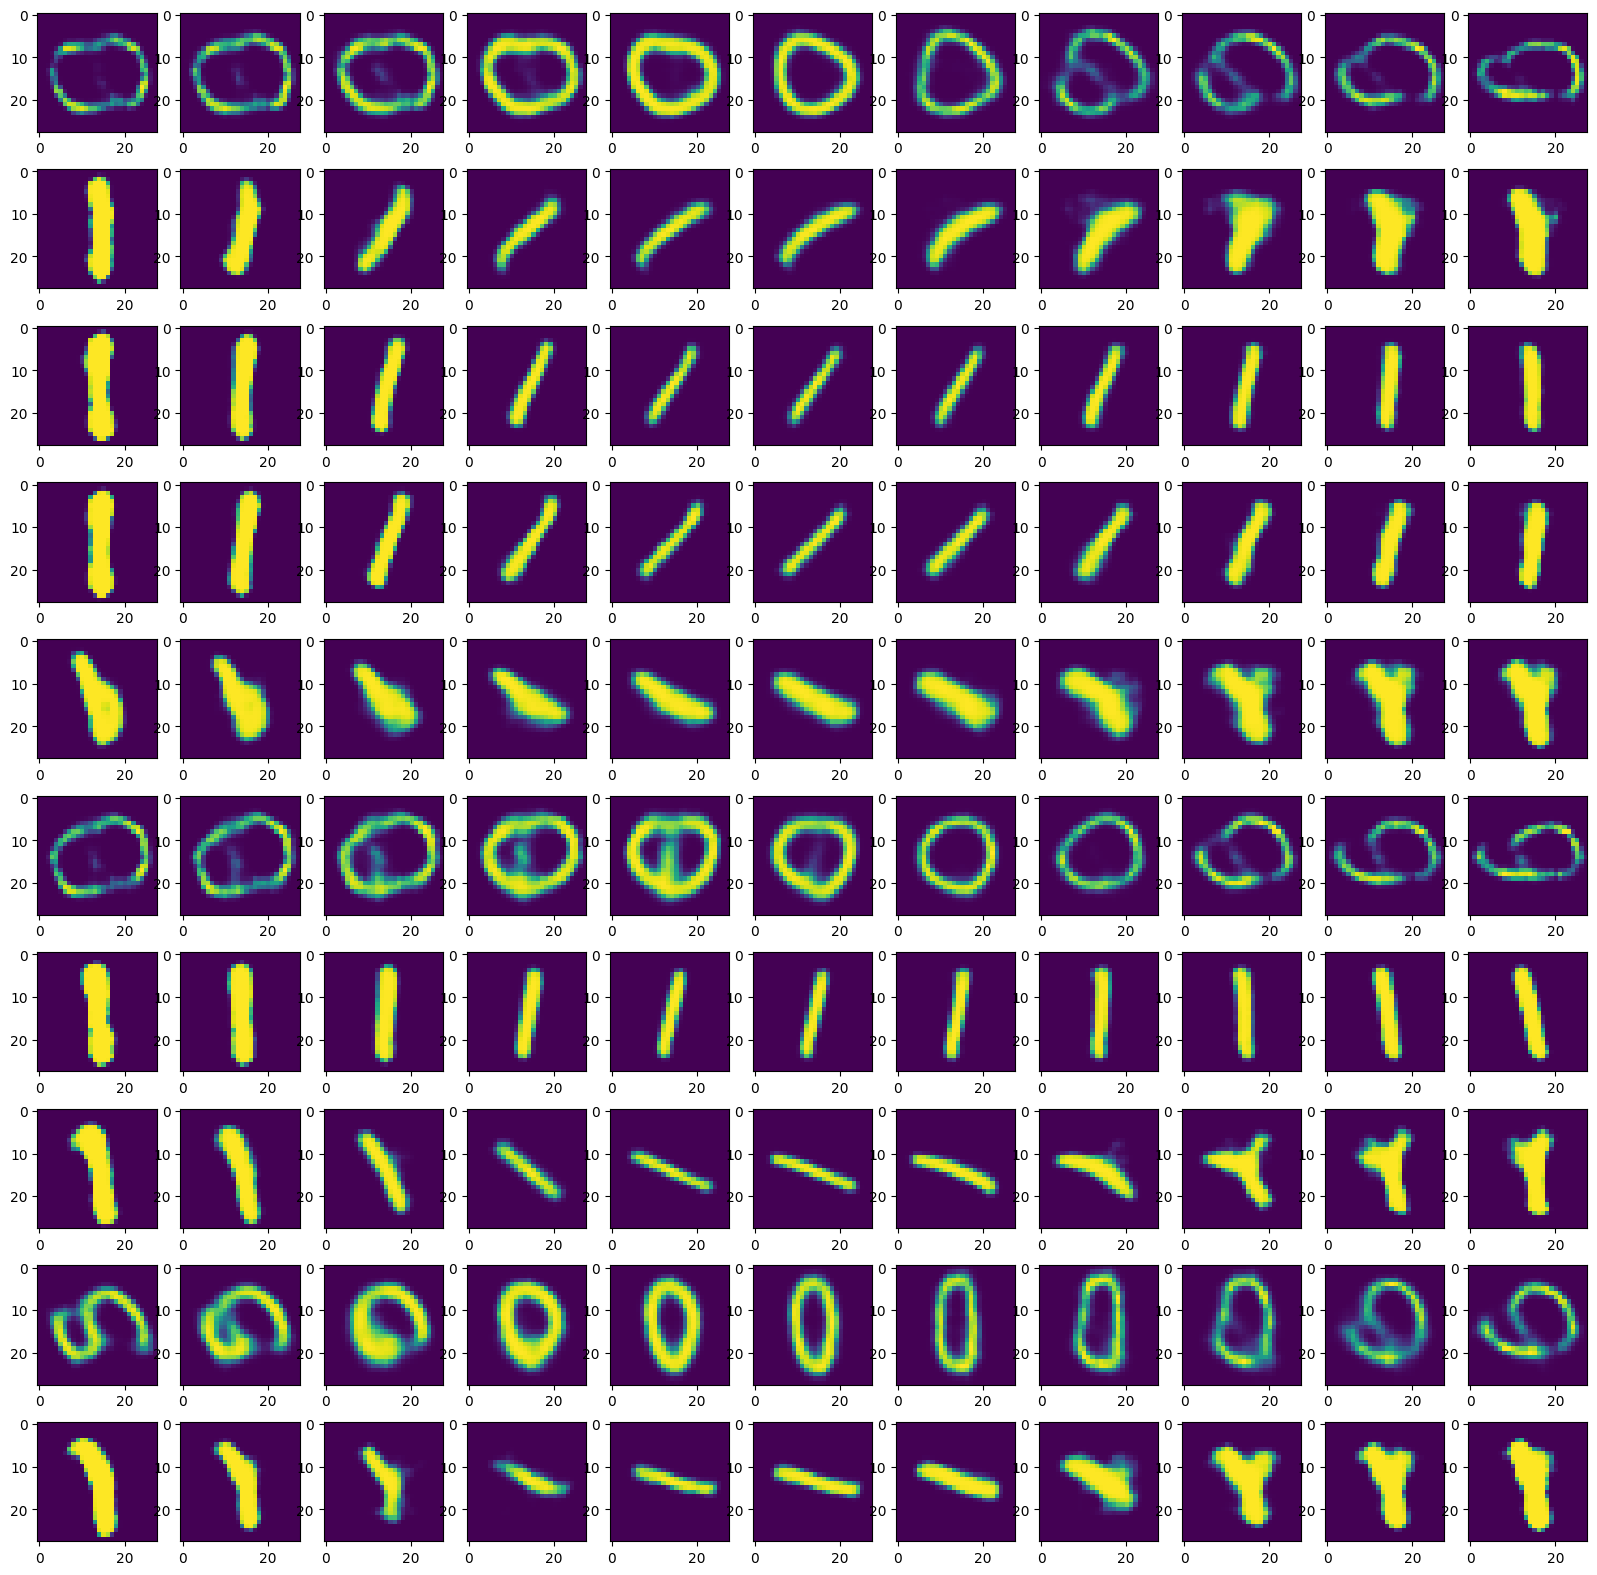

In [48]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,theta*(step),zero],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

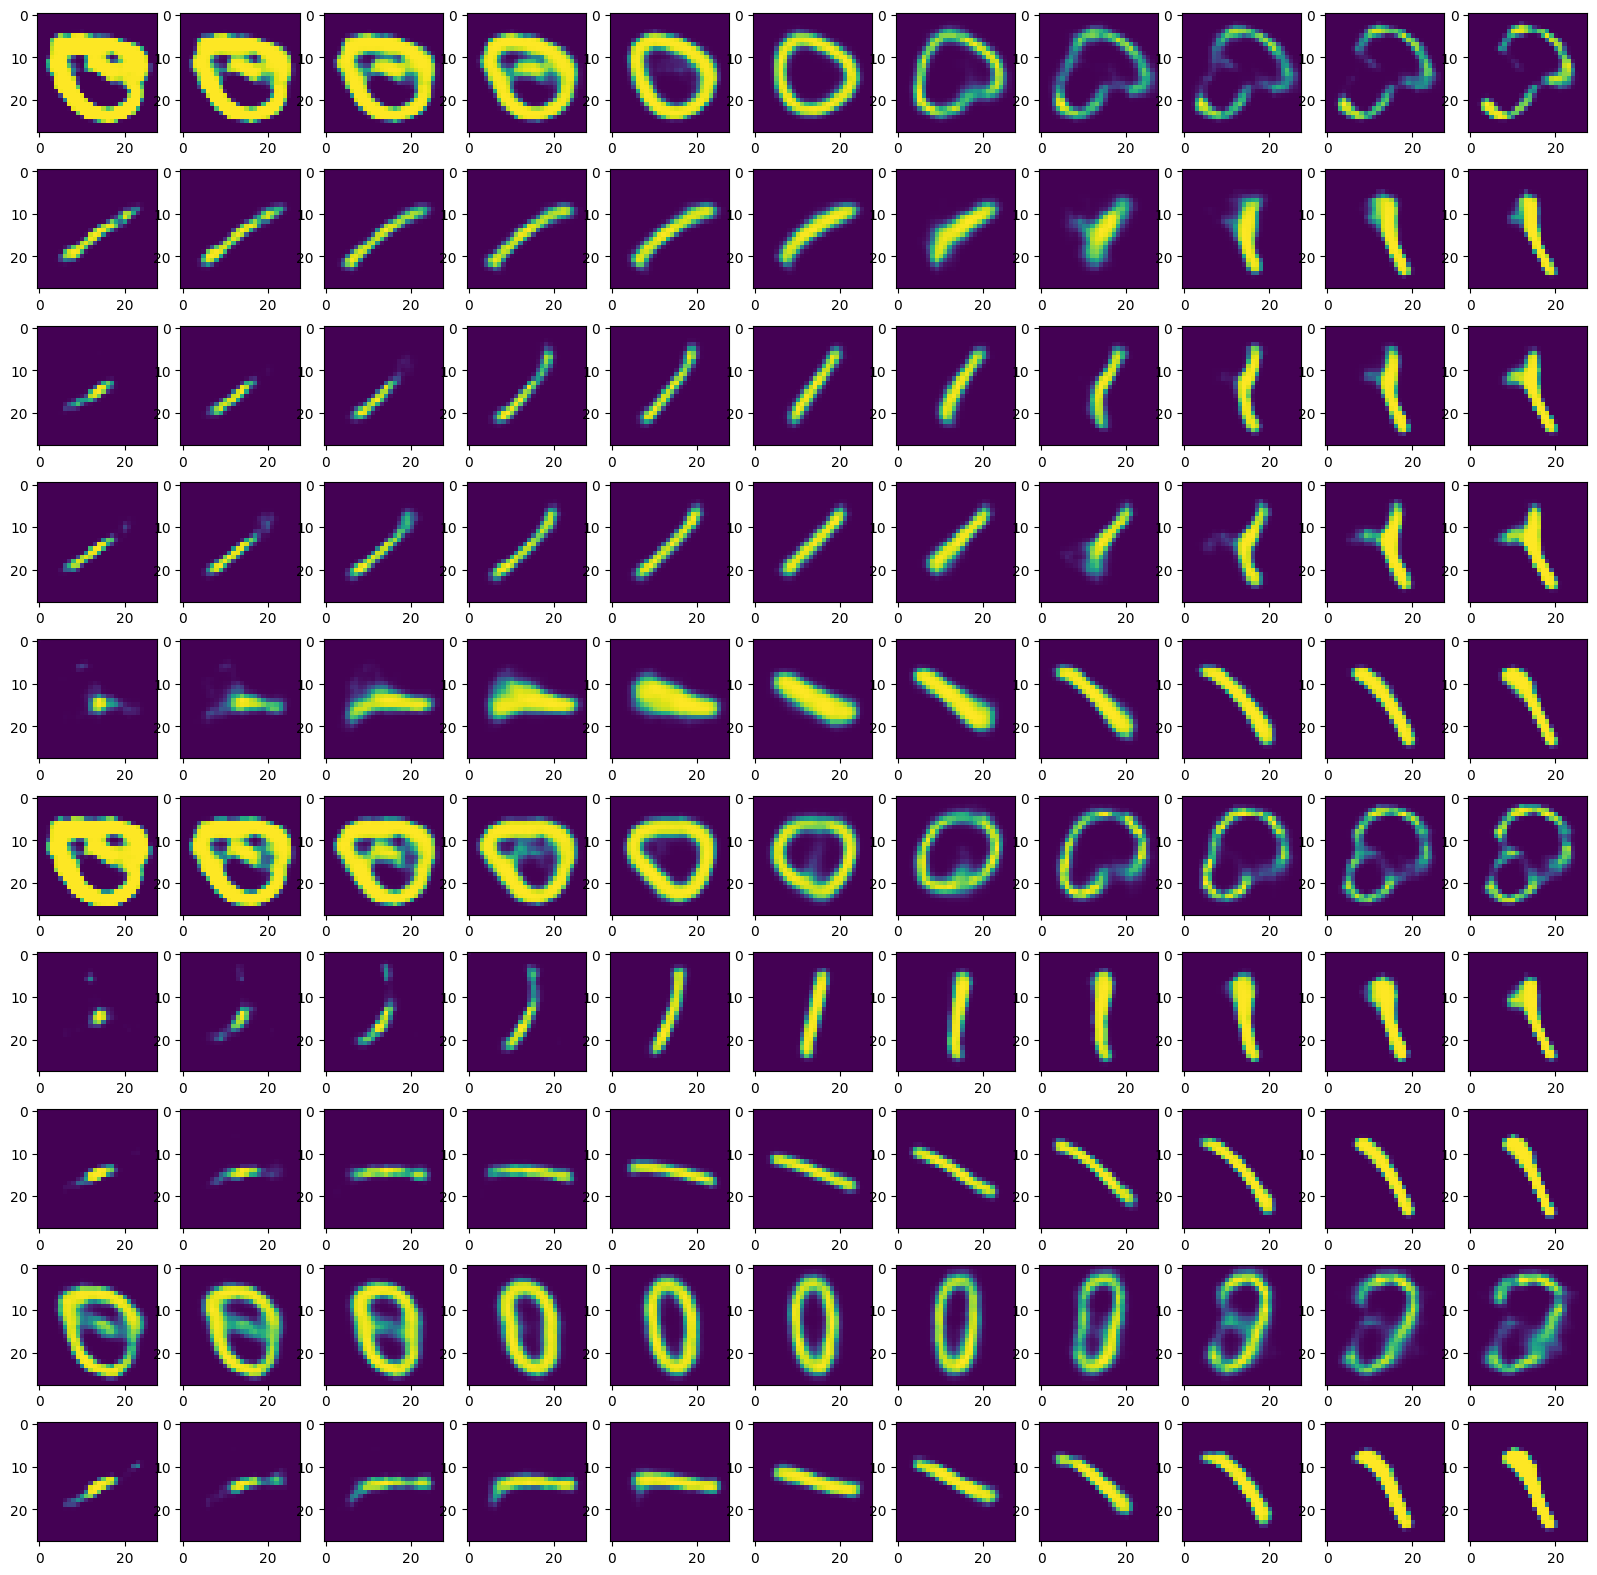

In [49]:
fig,axs = plt.subplots(10,11, figsize = (20,20))


for i in range(10):
    for j,step in enumerate(np.arange(-1,1.2,0.2)):
        axs[i,j].imshow(torch.sigmoid(model_VAE.decoder(model_fd(model_symmetry([zero,zero,theta*(step)],model_fe(X)))[:,:,None,None])).detach().cpu()[i,0,:,:])

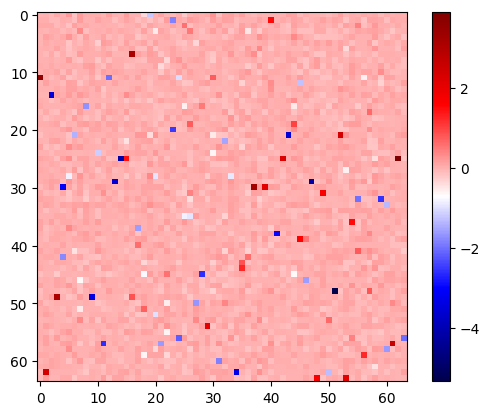

In [53]:
plt.imshow(model_symmetry.group[0].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

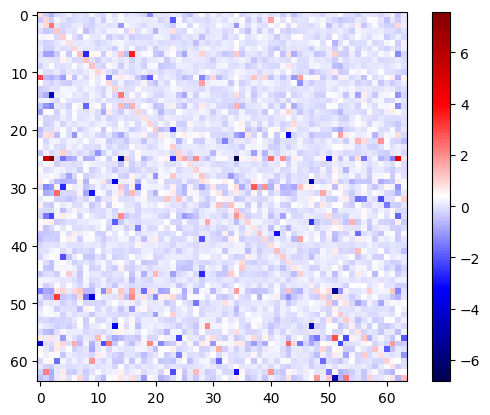

In [54]:
plt.imshow(torch.matrix_exp(model_symmetry.group[0].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

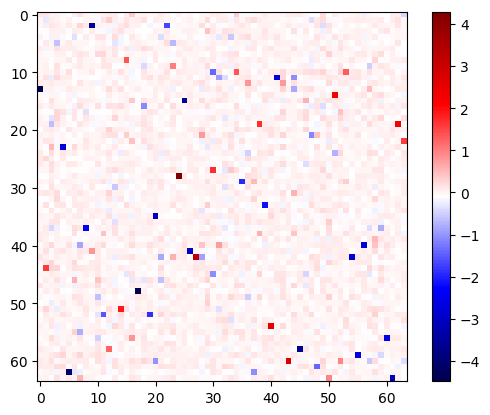

In [55]:
plt.imshow(model_symmetry.group[1].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

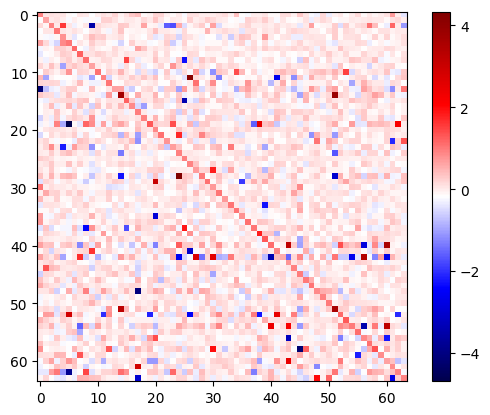

In [56]:
plt.imshow(torch.matrix_exp(model_symmetry.group[1].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()

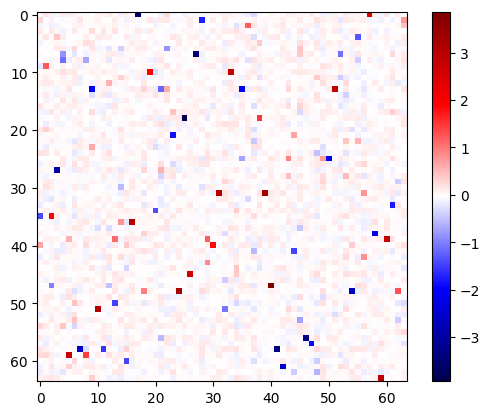

In [57]:
plt.imshow(model_symmetry.group[2].algebra.cpu().detach(),cmap = "seismic")
plt.colorbar()

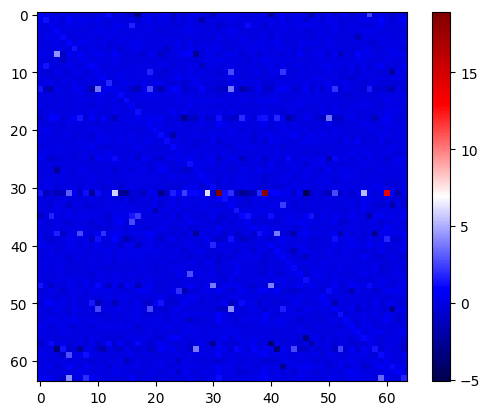

In [58]:
plt.imshow(torch.matrix_exp(model_symmetry.group[2].algebra.cpu().detach()),cmap = "seismic")
plt.colorbar()